In [2]:
from typing import Union
from transformers import AutoTokenizer, LogitsProcessorList, AutoModelForCausalLM

MODEL_PATH = 'THUDM/glm-4-9b-chat-hf'
import os
# 设置 HTTP 代理
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'

# 设置 HTTPS 代理 
os.environ['https_proxy'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForCausalLM.from_pretrained(MODEL_PATH, device_map="auto").eval()

def process_model_outputs(inputs, outputs, tokenizer):
    responses = []
    for input_ids, output_ids in zip(inputs.input_ids, outputs):
        response = tokenizer.decode(output_ids[len(input_ids):], skip_special_tokens=True).strip()
        responses.append(response)
    return responses


def batch(
        model,
        tokenizer,
        messages: Union[str, list[str]],
        max_input_tokens: int = 8192,
        max_new_tokens: int = 8192,
        num_beams: int = 1,
        do_sample: bool = True,
        top_p: float = 0.8,
        temperature: float = 0.8,
        logits_processor=None,
):
    if logits_processor is None:
        logits_processor = LogitsProcessorList()
    messages = [messages] if isinstance(messages, str) else messages
    batched_inputs = tokenizer(
        messages,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_input_tokens).to(model.device)
    
    gen_kwargs = {
        "max_new_tokens": max_new_tokens,
        "num_beams": num_beams,
        "do_sample": do_sample,
        "top_p": top_p,
        "temperature": temperature,
        "logits_processor": logits_processor,
        "eos_token_id": model.config.eos_token_id
    }
    batched_outputs = model.generate(**batched_inputs, **gen_kwargs)
    batched_response = process_model_outputs(batched_inputs, batched_outputs, tokenizer)
    return batched_response


def gen_caption(batch_message):

    # batch_message = [
    #     [
    #         {"role": "user", "content": "我的爸爸和妈妈结婚为什么不能带我去"},
    #         {"role": "assistant", "content": "因为他们结婚时你还没有出生"},
    #         {"role": "user", "content": "我刚才的提问是"}
    #     ],
    #     [
    #         {"role": "user", "content": "你好，你是谁"}
    #     ]
    # ]

    batch_inputs = []
    max_input_tokens = 128
    for i, messages in enumerate(batch_message):
        new_batch_input = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)[12:]
        max_input_tokens = max(max_input_tokens, len(new_batch_input))
        batch_inputs.append(new_batch_input)
    gen_kwargs = {
        "max_input_tokens": max_input_tokens,
        "max_new_tokens": 256,
        "do_sample": True,
        "top_p": 0.8,
        "temperature": 0.8,
        "num_beams": 1,
    }

    batch_responses = batch(model, tokenizer, batch_inputs, **gen_kwargs)
    return batch_responses
    for response in batch_responses:
        print("=" * 10)
        print(response)

Loading checkpoint shards: 100%|██████████| 4/4 [02:55<00:00, 43.98s/it]


In [3]:
def gen_batch_ques(ques):
    out_put=[]
    for i in ques:
        temp_dic={"role": "user"}
        temp_dic["content"]="Extract useful information about pedestrian appearance from the following sentences, remove all environmental information, descriptions about image clarity, person orientation, or visibility of certain appearance features, and rephrase it using a single passage of natural language:"+str(i)
        out_put.append(temp_dic)
    return out_put


In [ ]:
import json
from torch.utils.data import DataLoader, DistributedSampler
def load_data(path):

    with open(path, 'r', encoding='utf-8') as file:
        data_re_id = json.load(file)
    assert isinstance(data_re_id, list), "数据应为列表格式"
    # 为每条数据添加唯一索引，用于分布式处理
    for idx, item in enumerate(data_re_id):
        item["index"] = idx
    return data_re_id

def create_dataloader(data_re_id, batch_size=64, rank=0, world_size=1):
    sampler = DistributedSampler(data_re_id, rank=rank, num_replicas=world_size, shuffle=True)
    dataloader = DataLoader(data_re_id, batch_size=batch_size, sampler=sampler, collate_fn=lambda x: x)
    return dataloader, sampler

path="./output_merged.json"
data_loader=create_dataloader(load_data(path),batch_size=4)
for i in data_loader:
    pass

数据总长度: 40206
[{'role': 'user', 'content': 'Extract useful information about pedestrian appearance from the following sentences, remove all environmental information, descriptions about image clarity, person orientation, or visibility of certain appearance features, and rephrase it using a single passage of natural language:[\'The background is blurred, but it appears to be an urban setting with some buildings and possibly a street\', "The person\'s face is not visible in the image", \'The person is walking towards the camera, and there are no other people or objects in the immediate vicinity\', "The image does not provide any additional context or information about the person\'s identity or the location", \'The image is a close-up photograph of a person walking on a sidewalk\', \'The individual is carrying a black bag on their shoulder\', \'The person is wearing a black top and black pants\']'}]
sentences ['The individual in the photograph is a pedestrian wearing a black top and black 

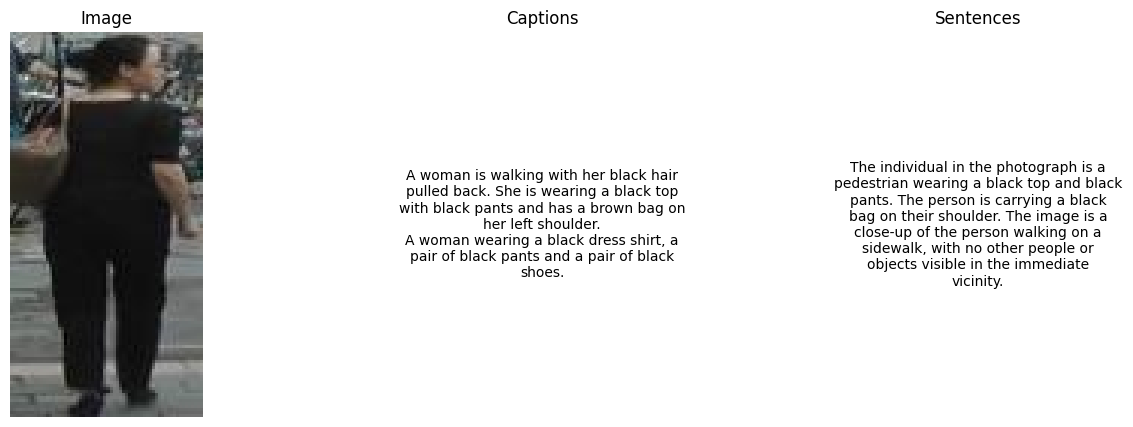

[{'role': 'user', 'content': 'Extract useful information about pedestrian appearance from the following sentences, remove all environmental information, descriptions about image clarity, person orientation, or visibility of certain appearance features, and rephrase it using a single passage of natural language:[\'The person is the central figure in the image, captured from behind and slightly to the side\', "The person\'s face is not visible due to the angle and the blur of the image", \'There are no other discernible objects or people in the image\', \'The background is indistinct, but it appears to be a well-lit indoor environment with some sort of reflective surface, possibly a glass or polished floor\', "The overall impression is of a solitary figure in motion, with the focus on the person\'s posture and the way they are carrying their bag", \'The individual is wearing dark clothing, which includes a jacket and pants, and is carrying a bag on their shoulder\', \'The image is a low-

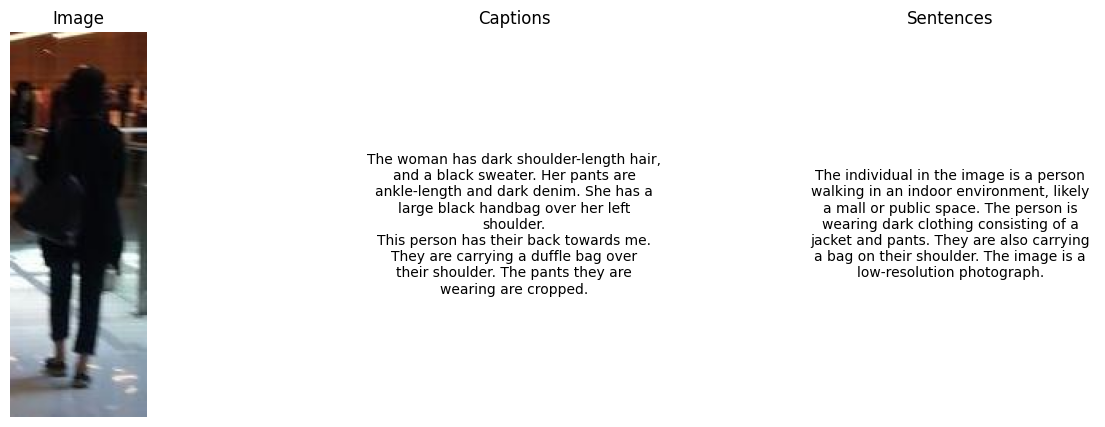

[{'role': 'user', 'content': 'Extract useful information about pedestrian appearance from the following sentences, remove all environmental information, descriptions about image clarity, person orientation, or visibility of certain appearance features, and rephrase it using a single passage of natural language:[\'The woman appears to be looking at her phone, which is in her hand\', \'She has a yellow backpack on her back and is holding a white object in her hand\', "The image is slightly blurry, and the woman\'s face is not visible", \'The woman in the image is wearing a pink top and black shorts\', \'She is wearing red shoes and has a bracelet on her wrist\', \'There is a panda statue to her right\', \'The woman is standing in a park-like setting with trees and a blue structure in the background\']'}]
sentences ['The woman depicted in the image is seen wearing a pink top, black shorts, red shoes, and a bracelet on her wrist. She is carrying a yellow backpack and holding a white object

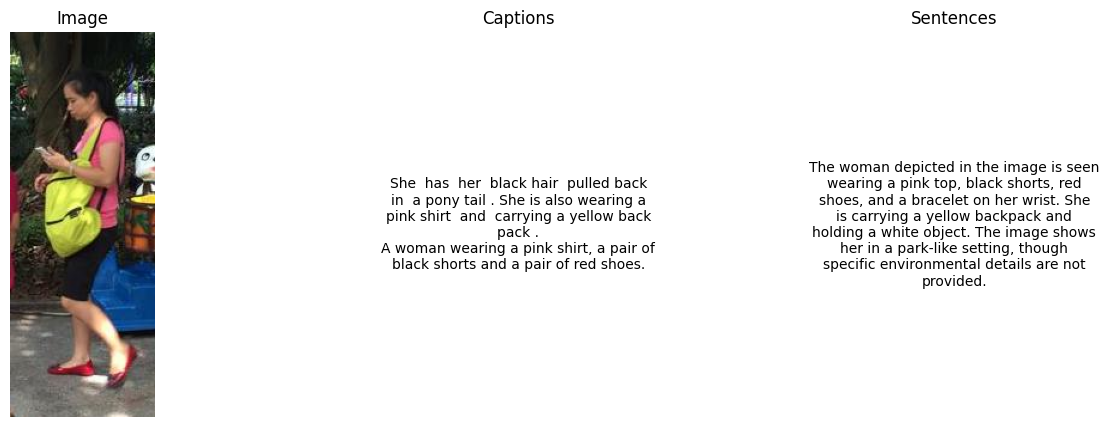

[{'role': 'user', 'content': "Extract useful information about pedestrian appearance from the following sentences, remove all environmental information, descriptions about image clarity, person orientation, or visibility of certain appearance features, and rephrase it using a single passage of natural language:['The overall atmosphere is one of companionship and leisure', 'Both are dressed casually, with the person on the right sporting black sandals', 'The person on the left, clad in a black shirt, is slightly ahead of the other', 'They are walking on a white floor, their path marked by a white line', 'The person on the right, donning a blue cap, is slightly behind', 'The image captures a moment of two individuals strolling hand in hand', 'The image is taken from a low angle, adding a sense of depth and perspective to the scene']"}]
sentences ['Both individuals are dressed casually; one wears black sandals and a blue cap, while the other is ahead, wearing a black shirt. They are walki

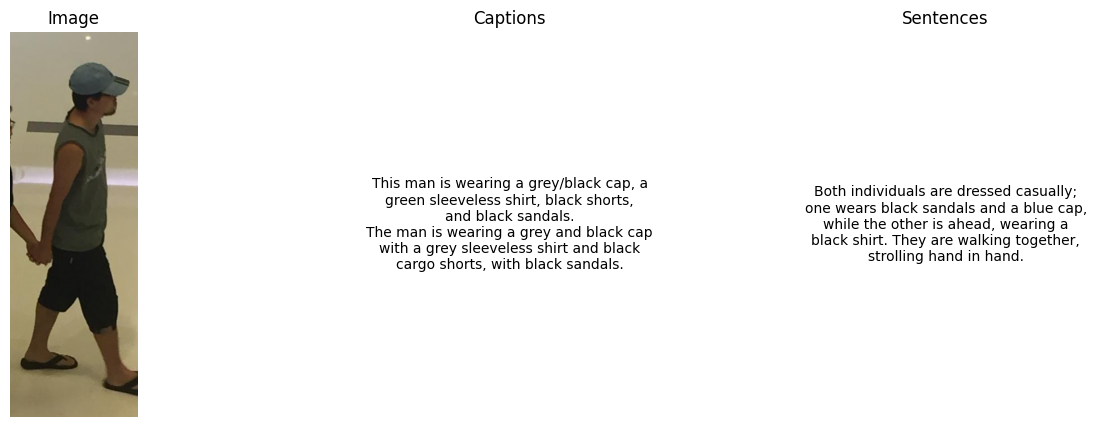

[{'role': 'user', 'content': "Extract useful information about pedestrian appearance from the following sentences, remove all environmental information, descriptions about image clarity, person orientation, or visibility of certain appearance features, and rephrase it using a single passage of natural language:['The person is carrying a blue bag on their shoulder and has a watch on their left wrist', 'a person walking on a brick-paved pathway, wearing a black top with a floral pattern on the sleeves, blue jeans, and white shoes', 'The person is not carrying any other bags or items, and there are no other people visible in the image', 'The surroundings include trees and a covered walkway or shelter in the background']"}]
sentences ['The person is wearing a black top with a floral pattern, blue jeans, and white shoes. They are carrying a blue bag on their shoulder and wearing a watch on their left wrist.']


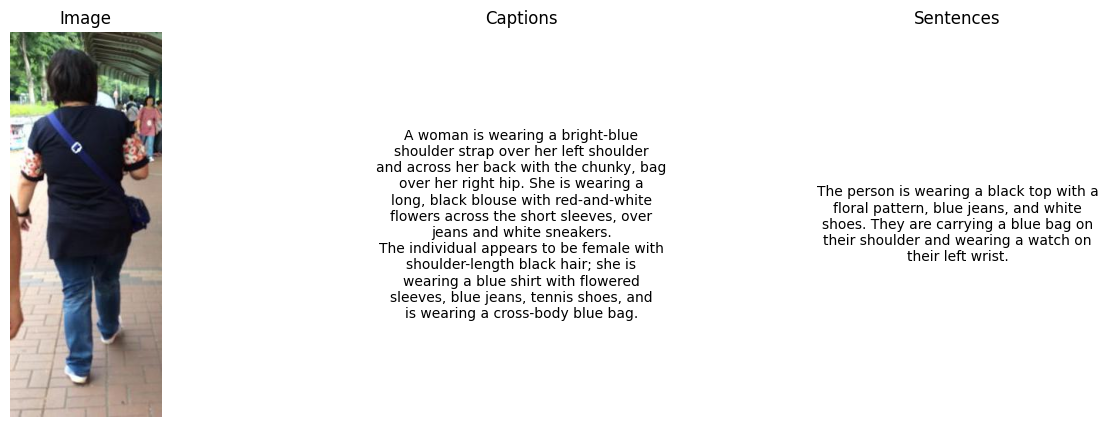

In [4]:
import os
import json
import random
import matplotlib.pyplot as plt
from PIL import Image
import textwrap

# 加载 JSON 文件
with open("./output_merged.json", 'r', encoding='utf-8') as file:
    data_re_id = json.load(file)

print(f"数据总长度: {len(data_re_id)}")

# 随机抽取五个样本
random_samples = random.sample(data_re_id, 5)

# 处理随机抽取的样本
for i, item in enumerate(random_samples):
    # 提取图像路径和描述
    file_path = item['file_path']
    captions = item['captions']
    
    # 拼接完整路径
    full_path = os.path.join("/home/cxd/storage/proj/IRRA/_id/CUHK-PEDES/imgs", file_path)
    
    if os.path.exists(full_path):
        try:
            # 打开图像
            img = Image.open(full_path)
            
            # 创建一个 1x3 的布局
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            fig.subplots_adjust(wspace=0.5)  # 调整列之间的间距
            
            # 第一列：显示图像
            axes[0].imshow(img)
            axes[0].axis('off')  # 隐藏坐标轴
            axes[0].set_title("Image", fontsize=12)
            
            # 第二列：显示 captions
            wrapped_captions = "\n".join([textwrap.fill(caption, width=40) for caption in captions])
            axes[1].text(0.5, 0.5, wrapped_captions, fontsize=10, ha='center', va='center', wrap=True)
            axes[1].axis('off')  # 隐藏坐标轴
            axes[1].set_title("Captions", fontsize=12)
            
            # 第三列：显示 sentences
            if 'generated_captions' in item:
                generated_caption = item['generated_captions'][0]
                sentences = generated_caption.split('.')  # 分割为句子
                sentences = [s.strip() for s in sentences if s.strip()]  # 去掉空白句子
                sentences=list(set(sentences))
                ques=gen_batch_ques([sentences])
                print(ques)
                # assert False
                sentences = gen_caption([ques])  
                print("sentences",sentences)
                wrapped_sentences = "\n".join([textwrap.fill(sentence, width=40) for sentence in sentences])
            else:
                wrapped_sentences = "No generated captions available."
            axes[2].text(0.5, 0.5, wrapped_sentences, fontsize=10, ha='center', va='center', wrap=True)
            axes[2].axis('off')  # 隐藏坐标轴
            axes[2].set_title("Sentences", fontsize=12)
            
            # 显示最终结果
            plt.show()
        except Exception as e:
            print(f"加载图像时发生错误: {e}")
    else:
        print(f"图像文件未找到: {full_path}")